## Google App Store Data Analysis

## NAME : SHAM AMBADAS JOHARI



## Background

Users download apps for various usage purposes. Given that paid service is usually better at offering pleasant experience, and that free apps are more accesible to everyone, what are the user opinions towards these apps? 

More specifically, the following questions are of interest:
- How do the app ratings differ between paid and free apps in general?
- How are the differences distributed across different app categories?
- Are there any categories where the differences are statistically significant?



In [29]:
# import packages

import pandas as pd
import seaborn as sns
import numpy as np
import re
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt


In [30]:
# Read dataframe and display data
df = pd.read_csv('Google Apps data.csv')
df.head(5)

,Unnamed: 0.1,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Last Updated,Current Ver,Minimum Android Ver,Genres
0,0,0,Photo Editor & Candy Camera & Grid & ScrapBook,Art And Design,4.1,159,19.0,10000,Free,0.0,Others,"January 7, 2018",1.0.0,4.0.3,Art & Design
1,1,1,Coloring book moana,Art And Design,3.9,967,14.0,500000,Free,0.0,Others,"January 15, 2018",2.0.0,4.0.3,Art & Design
2,2,5,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Art And Design,4.7,87510,8.7,5000000,Free,0.0,Others,"August 1, 2018",1.2.4,4.0.3,Art & Design
3,3,6,Sketch - Draw & Paint,Art And Design,4.5,215644,25.0,50000000,Free,0.0,Teen,"June 8, 2018",Varies with device,4.2,Art & Design
4,4,7,Pixel Draw - Number Art Coloring Book,Art And Design,4.3,967,2.8,100000,Free,0.0,Others,"June 20, 2018",1.1,4.4,Art & Design


### Step 0. Explore and Prepare Dataframe

In [31]:
# check duplicates
n_duplicated = df.duplicated(subset=['App']).sum()
print("There are {}/{} duplicated records.".format(n_duplicated, df.shape[0]))
df_no_dup = df.drop(df.index[df.App.duplicated()], axis=0)
print("{} records after dropping duplicated.".format(df_no_dup.shape[0]))

There are 86/8276 duplicated records.
8190 records after dropping duplicated.


In [32]:
# Check and clean type values, defer nan value processing to the next cell
print(set(df_no_dup.Type))
print("Dropping alien Type value '0', {} record(s) removed".format(sum(df_no_dup.Type == '0')))
df_no_dup = df_no_dup.drop(df_no_dup.index[df_no_dup.Type == '0'], axis=0)

{'Free', 'Paid'}
Dropping alien Type value '0', 0 record(s) removed


In [33]:
# check and drop NaN values
print("NaA value statistics in each column")
print(df_no_dup.isnull().sum(axis=0),'\n')
df_no_dup = df_no_dup.dropna(subset=['Type'])
print("Column 'Type' with NaN values are dropped, {} records left.".format(df_no_dup.shape[0]))

# prepare rating dataframe
df_rating = df_no_dup.dropna(subset=['Rating'])
print("Cleaned dataframe for 'Rating' has {} records.".format(df_rating.shape[0]))

NaA value statistics in each column
Unnamed: 0.1             0
Unnamed: 0               0
App                      0
Category                 0
Rating                   0
Reviews                  0
Size                     0
Installs                 0
Type                     0
Price                    0
Content Rating         361
Last Updated             0
Current Ver              0
Minimum Android Ver      0
Genres                   0
dtype: int64 

Column 'Type' with NaN values are dropped, 8190 records left.
Cleaned dataframe for 'Rating' has 8190 records.


In [34]:
# we are interested in the columns Category, Rating and Type
# Drop irrelevant columns for Rating dataframe.
df_rating = df_rating.loc[:,['Rating', 'Type', 'Category']]

In [35]:
def plot_hist(df, col, bins=10):
    """
    Plot histograms for a column
    """
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.title('Distribution of {}'.format(col))

def compute_app_types(df):
    """
    Given a dataframe, compute the number 
    of free and paid apps respectively
    """
    return sum(df.Type == "Free"), sum(df.Type == 'Paid')

def plot_app_types(df):
    """
    Plot app type distributions across categories
    """
    vc_rating = df.Category.value_counts()
    cat_free_apps = []
    cat_paid_apps = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        cat_free_apps.append(n_free)
        cat_paid_apps.append(n_paid)

    f, ax = plt.subplots(2,1)
    ax[0].bar(range(1, len(cat_free_apps)+1), cat_free_apps)
    ax[1].bar(range(1, len(cat_free_apps)+1), cat_paid_apps)

def drop_categories(df):
    """
    Drop categories with any app type with instances fewer than 10
    """
    vc_rating = df.Category.value_counts()
    cats_to_drop = []
    for cat in vc_rating.index:
        n_free, n_paid = compute_app_types(df.query("Category == '{}'".format(cat)))
        if n_free < 10 or n_paid < 10:
            cats_to_drop.append(cat)
    for cat in cats_to_drop:
        df.drop(df.query('Category == "{}"'.format(cat)).index, axis=0, inplace=True)
    print("Deleted categories: {}".format(cats_to_drop))
    return df

<AxesSubplot:xlabel='Content Rating', ylabel='Count'>

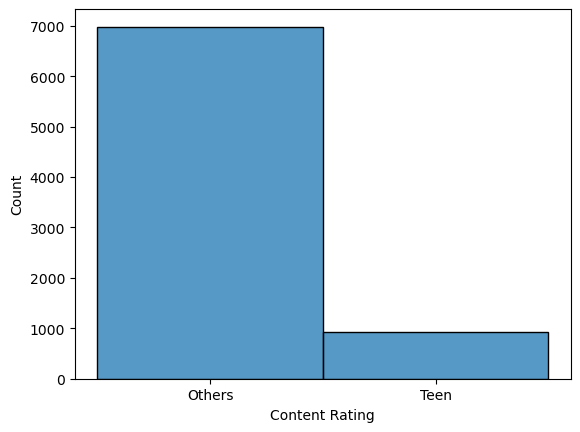

In [49]:
sns.histplot(df['Content Rating'])

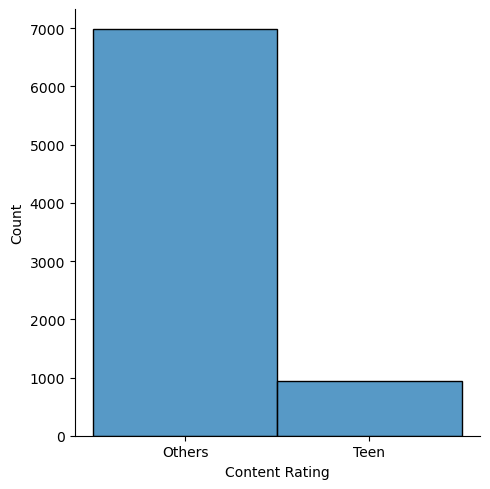

In [56]:

sns.displot(df['Content Rating'])

## check famous category

<AxesSubplot:xlabel='Category'>

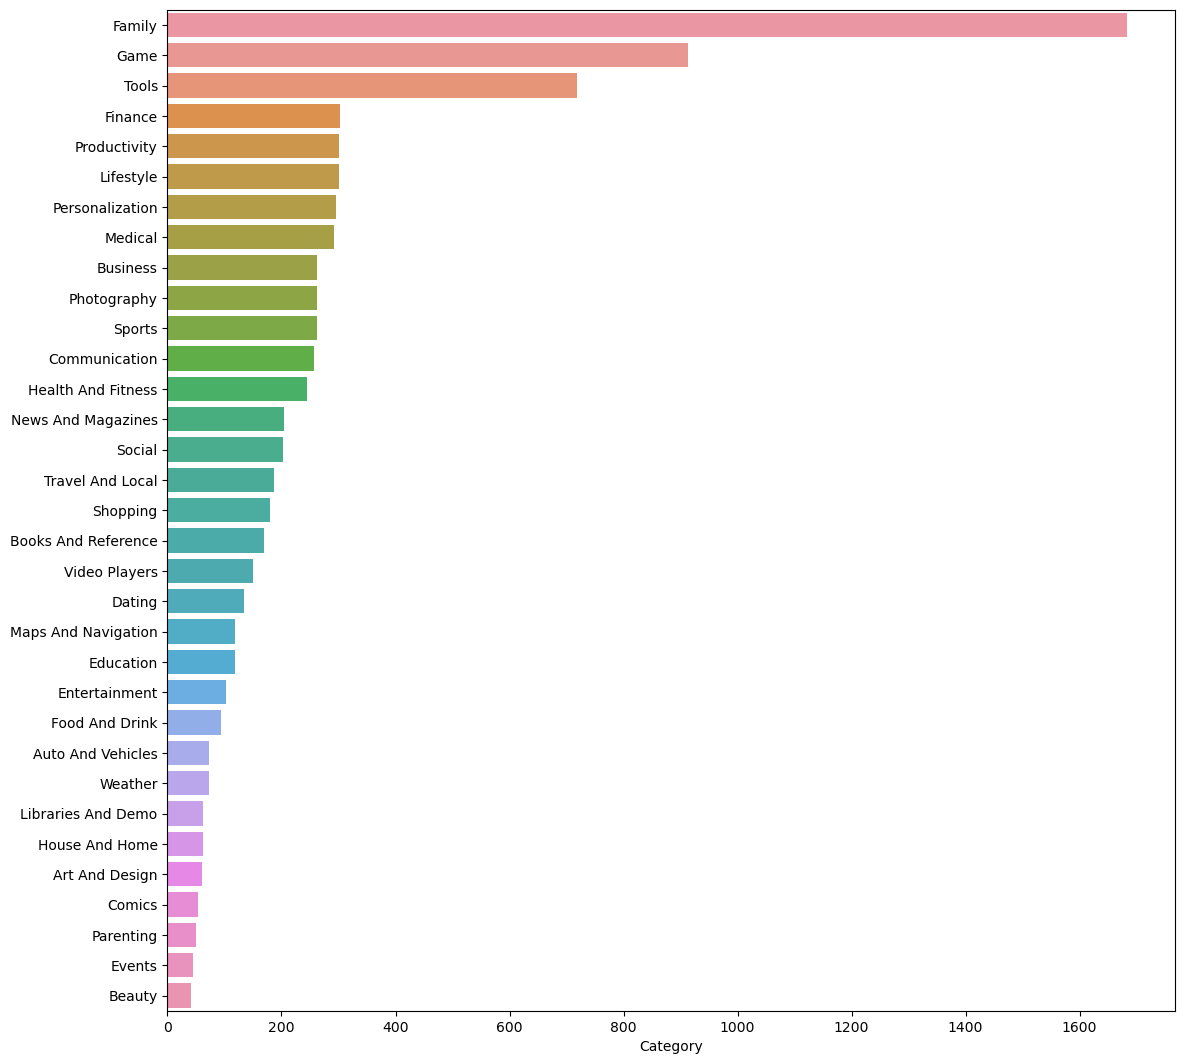

In [38]:
plt.figure(figsize = (13,13))
most_data = df.Category.value_counts()
sns.barplot(x = most_data , y = most_data.index , data = df)

## Bar Plot (Visualization)

<AxesSubplot:xlabel='Rating', ylabel='Category'>

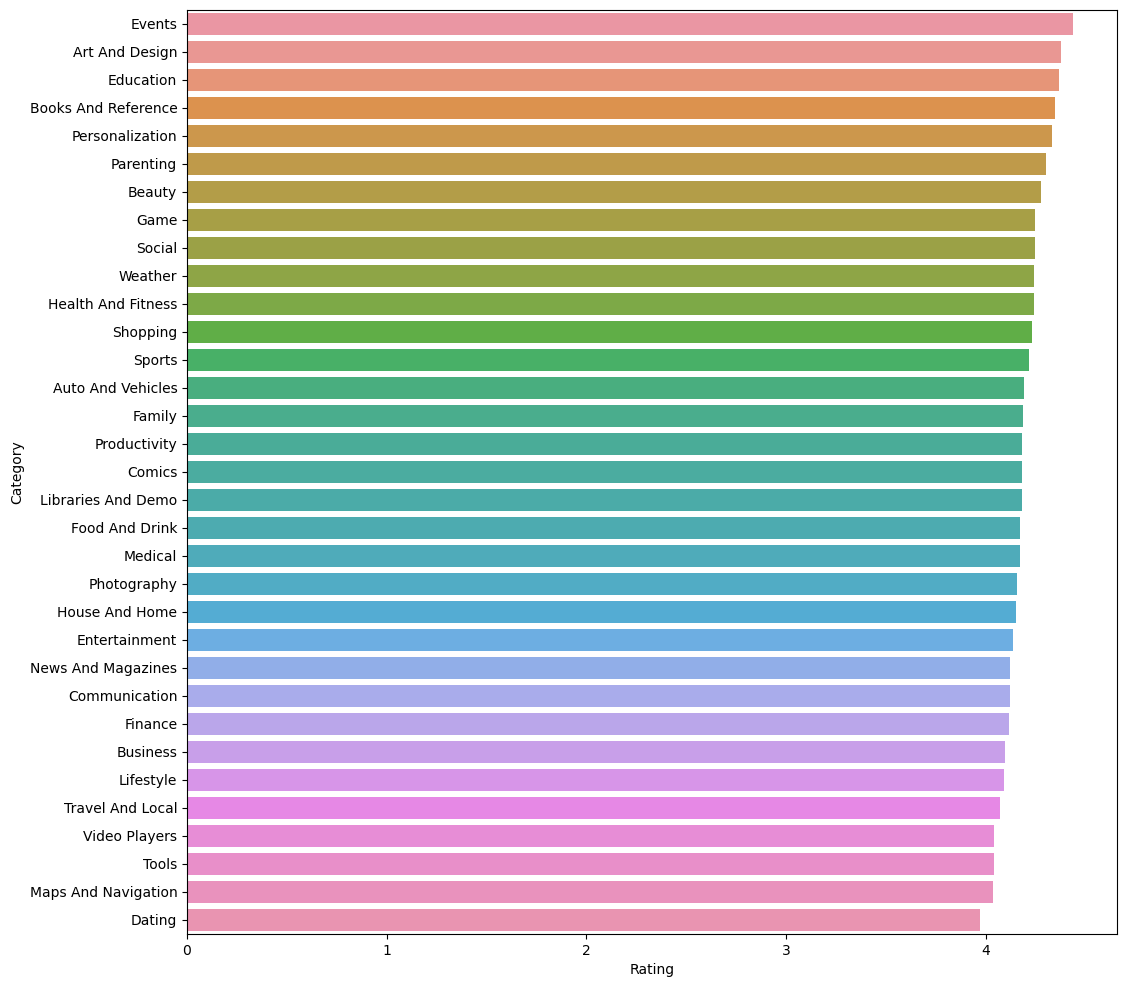

In [39]:
# Mean Rating
plt.figure(figsize=(12,12))
mean_rat = df.groupby(['Category'])['Rating'].mean().sort_values(ascending=False)
sns.barplot(x=mean_rat, y=mean_rat.index, data=df)

<AxesSubplot:xlabel='Reviews', ylabel='Category'>

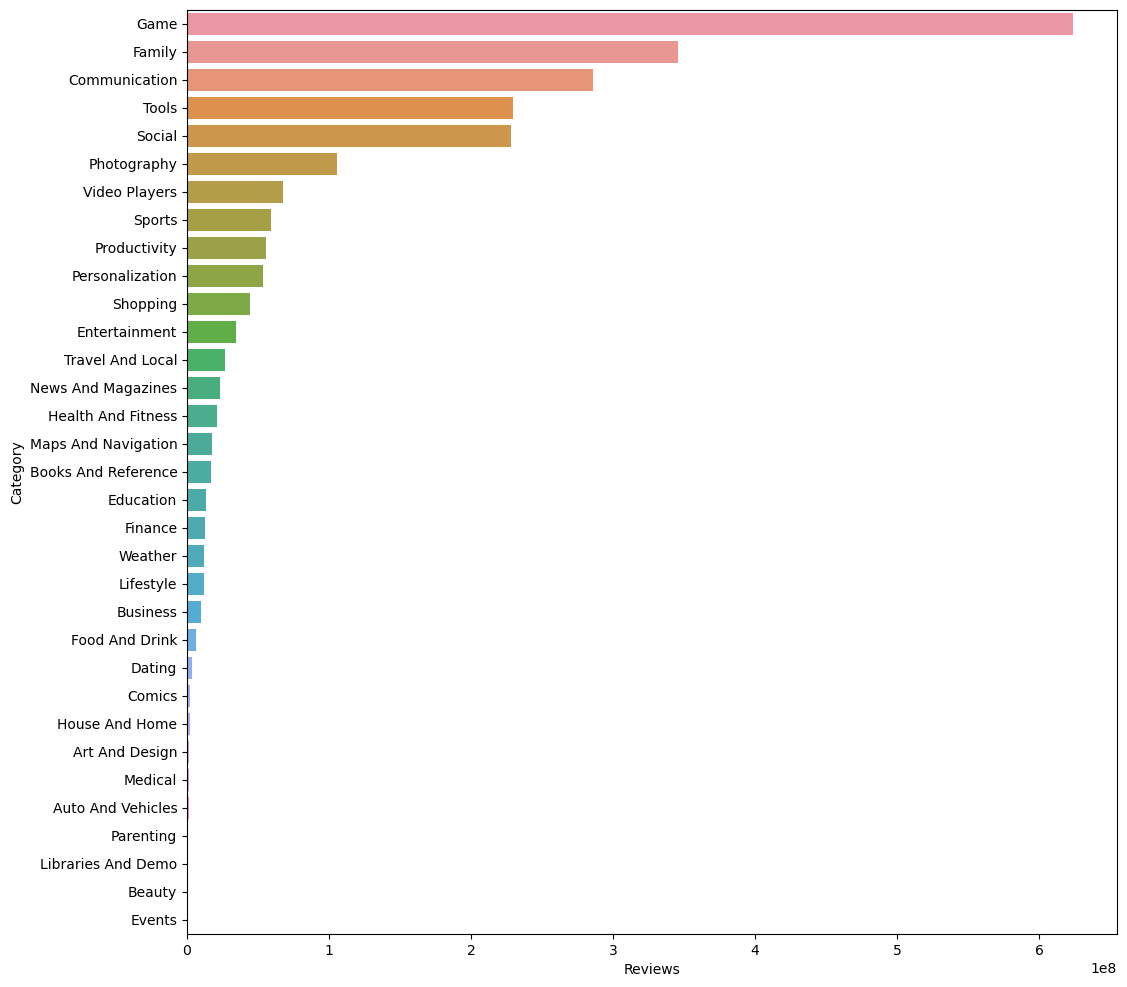

In [40]:
# Total reviews
plt.figure(figsize=(12,12))
sum_rew = df.groupby(['Category'])['Reviews'].sum().sort_values(ascending=False)
sns.barplot(x=sum_rew, y=sum_rew.index, data=df)

<AxesSubplot:xlabel='Reviews', ylabel='Category'>

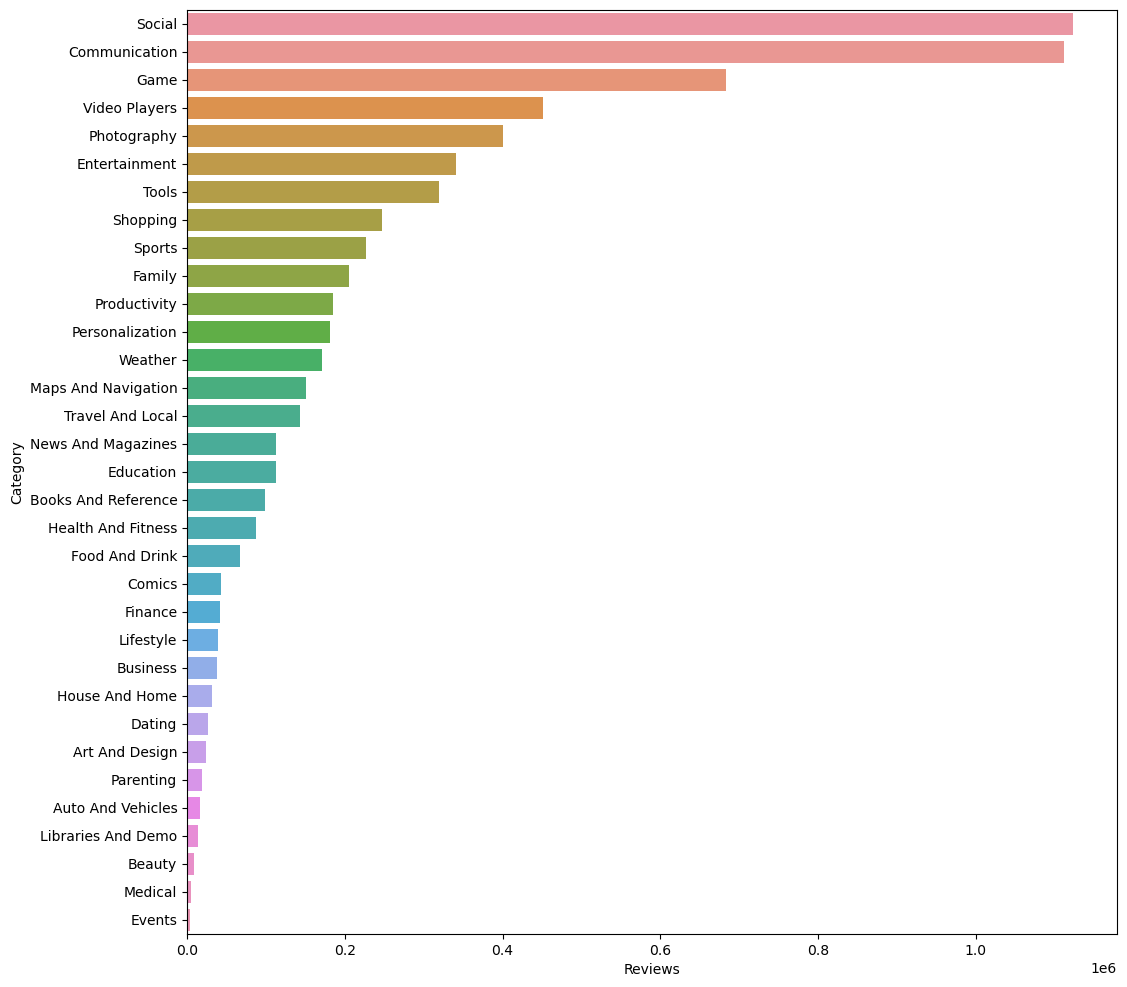

In [41]:
# Mean reviews
plt.figure(figsize=(12,12))
mean_rew = df.groupby(['Category'])['Reviews'].mean().sort_values(ascending=False)
sns.barplot(x=mean_rew, y=mean_rew.index, data=df)

<AxesSubplot:xlabel='Installs', ylabel='Category'>

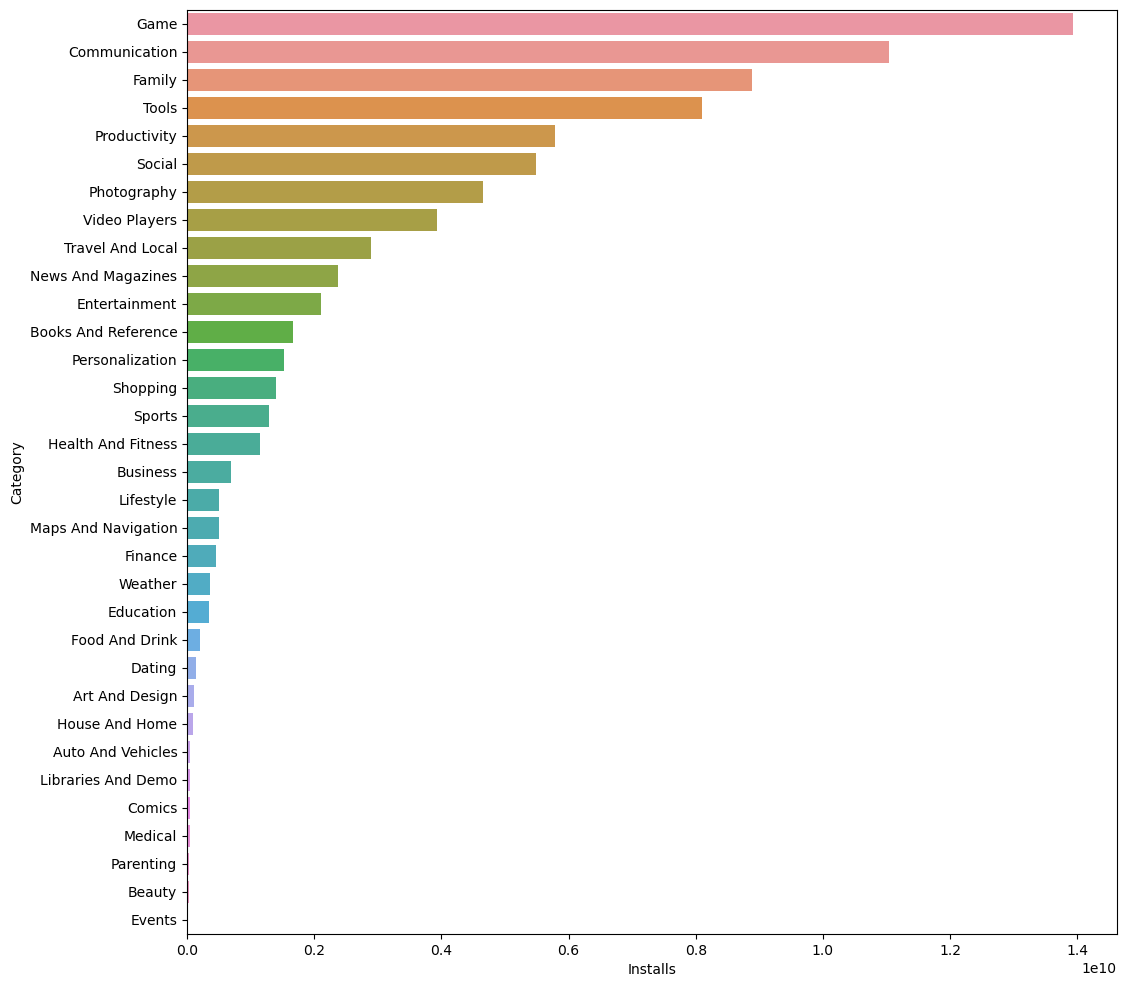

In [42]:
# Total Installs
plt.figure(figsize=(12,12))
sum_inst = df.groupby(['Category'])['Installs'].sum().sort_values(ascending=False)
sns.barplot(x=sum_inst, y=sum_inst.index, data=df)

<AxesSubplot:xlabel='Installs', ylabel='Category'>

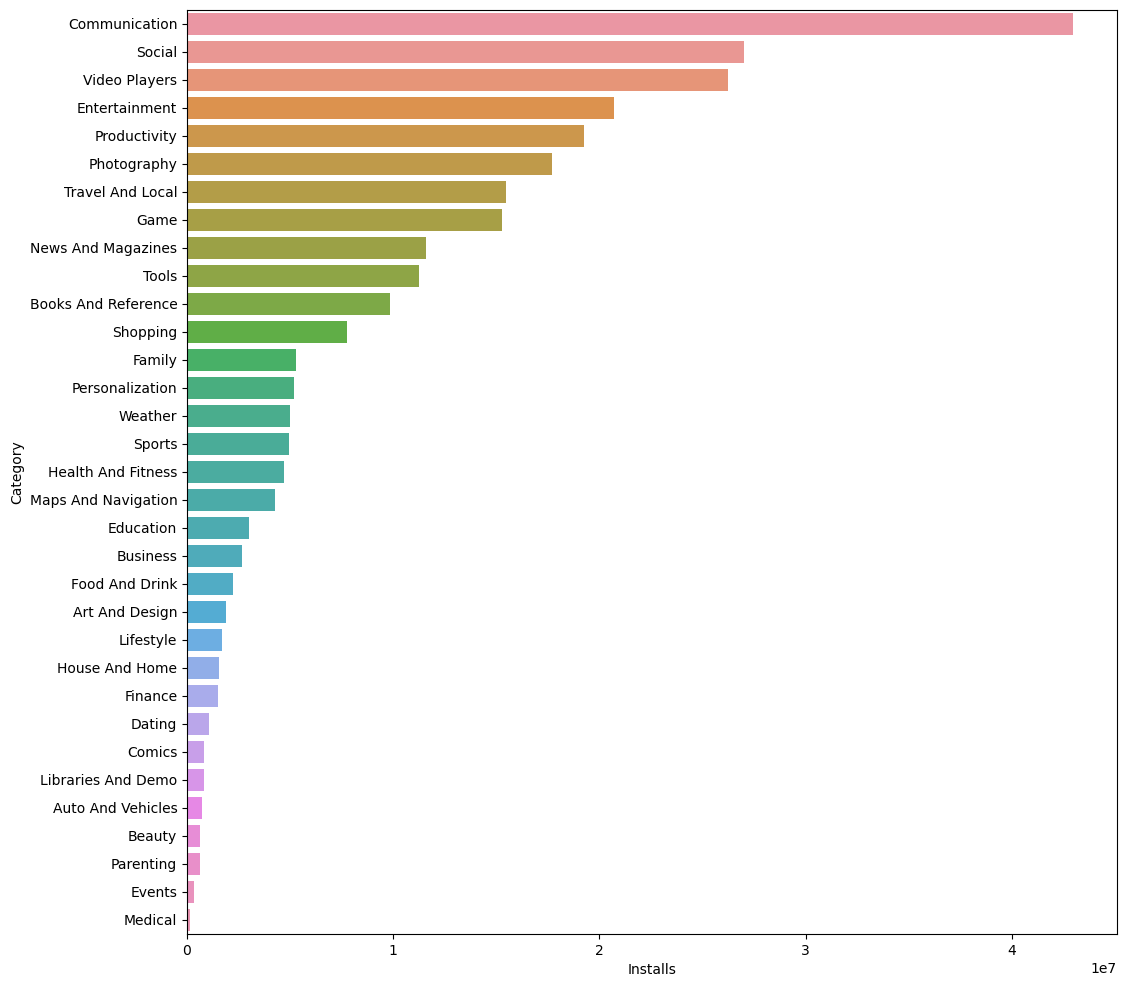

In [43]:
# Mean Install
plt.figure(figsize=(12,12))
mean_ints = df.groupby(['Category'])['Installs'].mean().sort_values(ascending=False)
sns.barplot(x=mean_ints, y=mean_ints.index, data=df)

In [45]:
print(df.groupby('Category')['Type'].value_counts())

Category           Type
Art And Design     Free     57
                   Paid      3
Auto And Vehicles  Free     72
                   Paid      1
Beauty             Free     42
                          ... 
Travel And Local   Paid      8
Video Players      Free    146
                   Paid      4
Weather            Free     65
                   Paid      7
Name: Type, Length: 61, dtype: int64


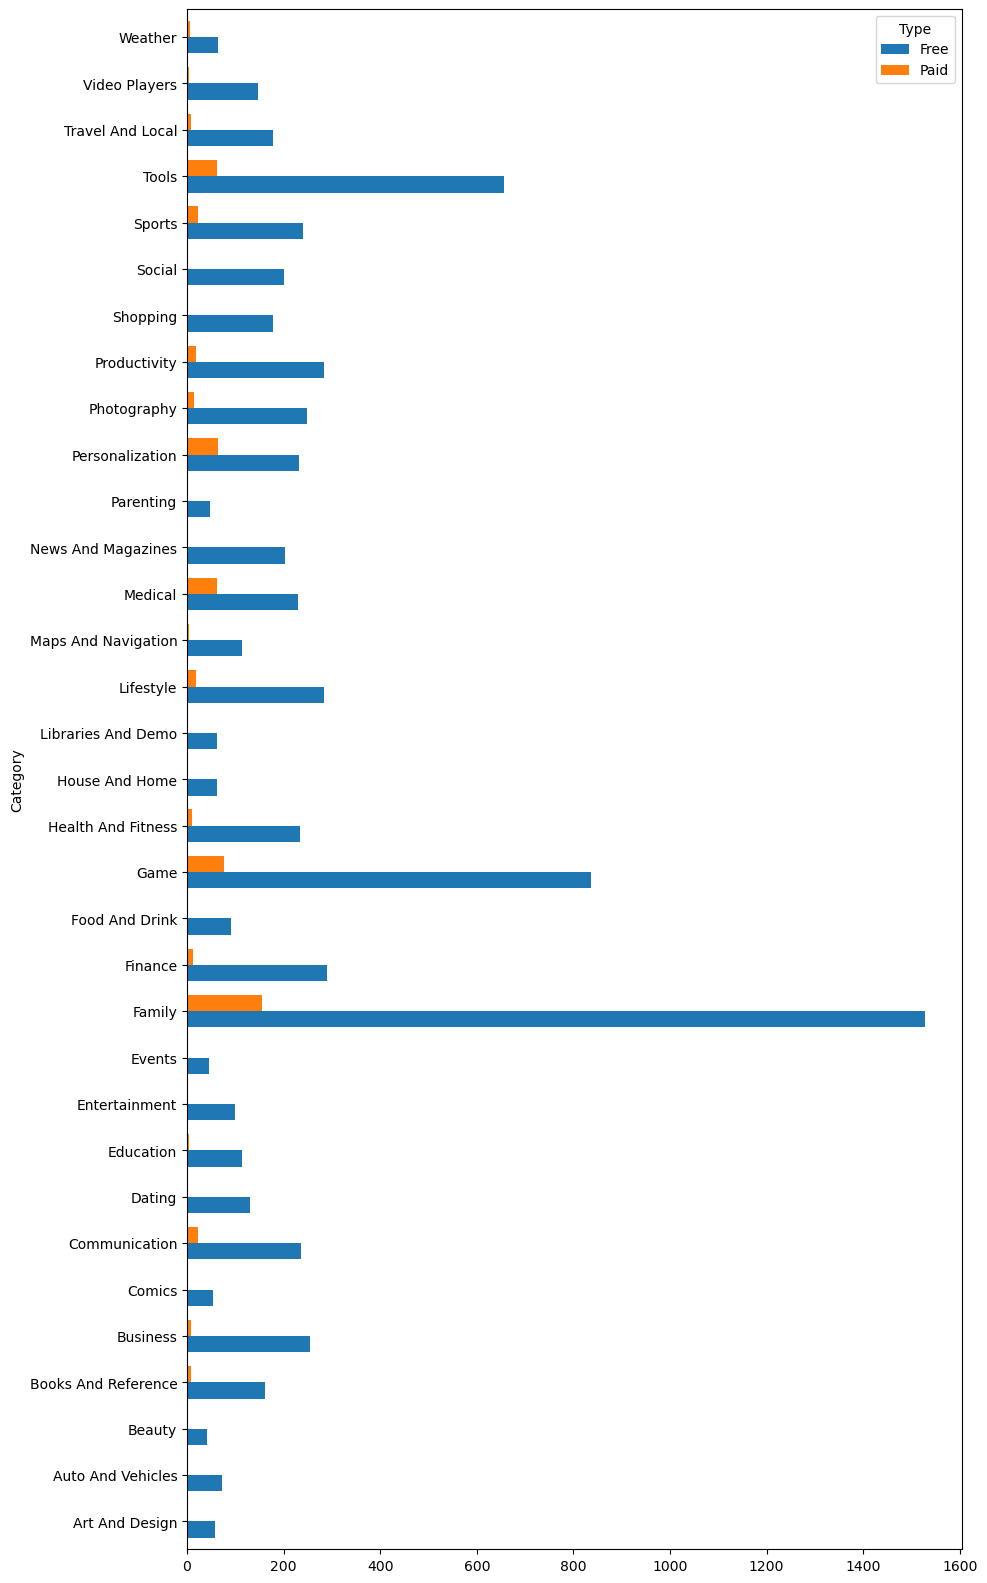

In [47]:

# plt.figure(figsize=(12,12))
Type_cat = df.groupby('Category')['Type'].value_counts().unstack().plot.barh(figsize=(10,20), width=0.7)
plt.show()

,Rating
count,8190.000000
mean,4.173321
std,0.536691
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


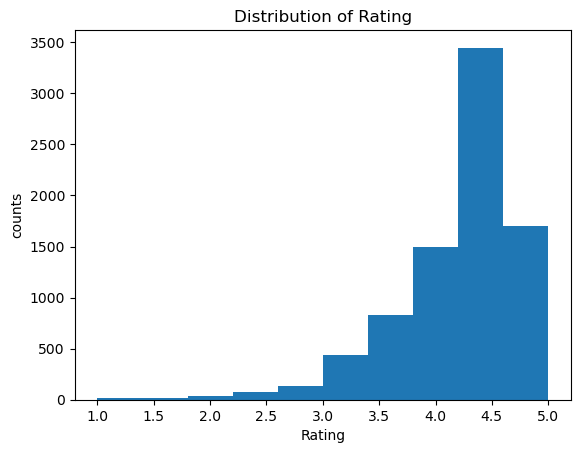

In [17]:
# Describe Rating dataframe
plot_hist(df_rating, 'Rating')
df_rating.describe()

In [18]:
print("There are {} free and {} paid apps in the the Rating dataframe ".format(*compute_app_types(df_rating)))

There are 7588 free and 602 paid apps in the the Rating dataframe 


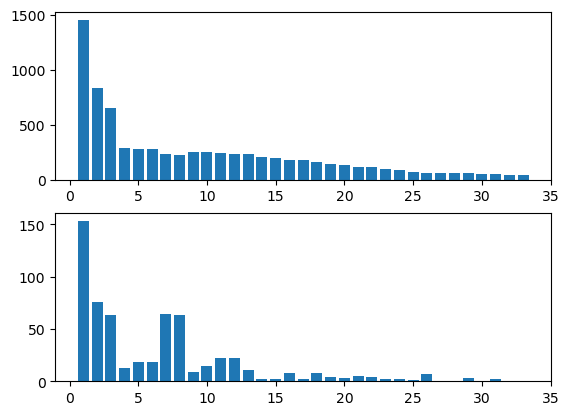

In [19]:
# explore the distributions of free and paid apps across different categories
plot_app_types(df_rating)

In [20]:
# Exclude categories with fewer than 10 apps for any Free or Paid type
# Otherwise the categories would contain too few data to generalize the result
df_rating = drop_categories(df_rating)
print("Cleaned Rating dataframe has {} datapoints".format(df_rating.shape[0]))

Deleted categories: ['Business', 'News And Magazines', 'Social', 'Travel And Local', 'Shopping', 'Books And Reference', 'Video Players', 'Dating', 'Maps And Navigation', 'Education', 'Entertainment', 'Food And Drink', 'Auto And Vehicles', 'Weather', 'Libraries And Demo', 'House And Home', 'Art And Design', 'Comics', 'Parenting', 'Events', 'Beauty']
Cleaned Rating dataframe has 5749 datapoints


In [21]:
df_rating.describe()

,Rating
count,5749.000000
mean,4.173126
std,0.545003
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


### Q 1. How does the ratings differ in general?

In [22]:
def plot_target_by_group(df, target_col, group_col, figsize=(6,4), title=""):
    """
    Plot the mean of a target column (Numeric) groupped by the group column (categorical)
    """
    order = sorted(list(set(df[group_col])))
    stats = df.groupby(group_col).mean()[target_col]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=group_col, y=target_col, data=df, ax=ax, order=order).set_title(title)
    ax.set(ylim=(3.8, 4.5))    
    return stats

Free app has average Rating 4.163423527154097
Paid app has average Rating 4.267100371747212
Mean rating: 4.173125761001916


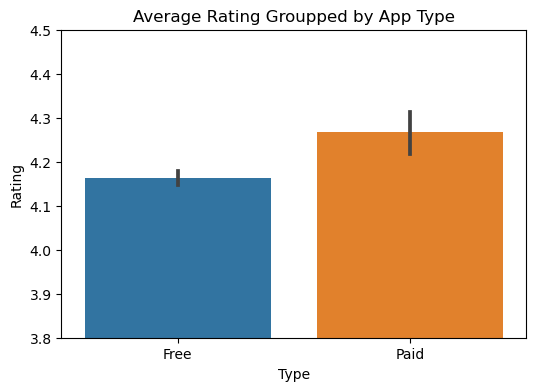

In [23]:
stats = plot_target_by_group(df_rating, 'Rating', 'Type', title="Average Rating Groupped by App Type")
for i, s in zip(stats.index, stats):
    print("{} app has average {} {}".format(i, 'Rating',s))
mean_rating = df_rating.Rating.mean()
print("Mean rating: {}".format(mean_rating))

#### Interpretation
In general, Free apps, with an average rating of 4.16, are lower rated than Paid apps with an average rating of 4.27. Note that the average rating for all apps is 4.17, so Free apps are rated below average, while Paid apps are rated reletively higher than the average score.

### Q2 How are the differences distributed across different app categories?

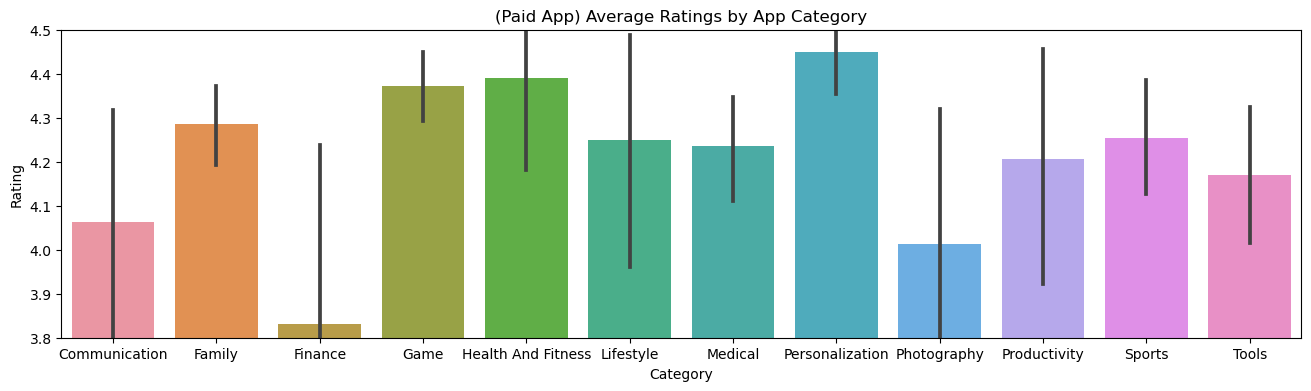

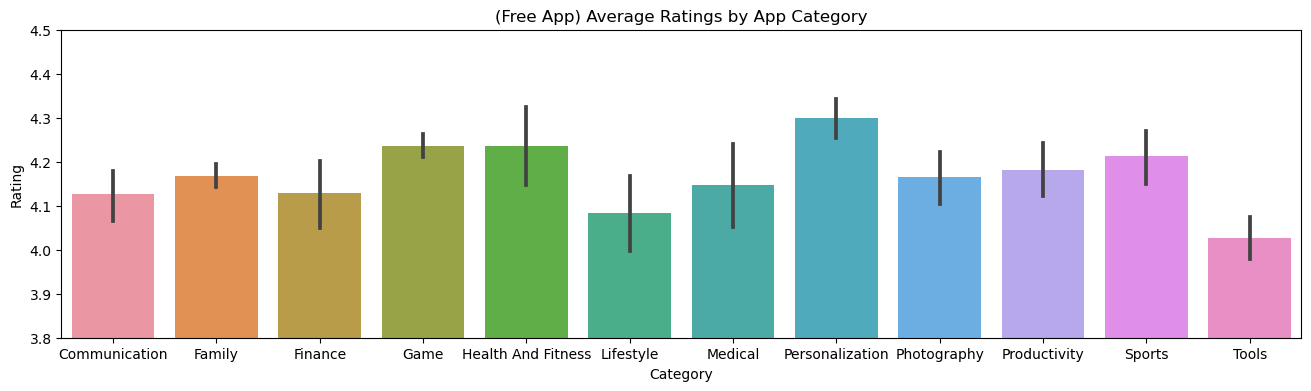

In [24]:
paid_stats = plot_target_by_group(df_rating.query('Type == "Paid"'), 'Rating', 'Category', (16, 4), "(Paid App) Average Ratings by App Category")
free_stats = plot_target_by_group(df_rating.query('Type == "Free"'), 'Rating', 'Category', (16, 4), "(Free App) Average Ratings by App Category")

Category
Communication        -0.063287
Family                0.116983
Finance              -0.297604
Game                  0.136364
Health And Fitness    0.154858
Lifestyle             0.166608
Medical               0.087344
Personalization       0.149300
Photography          -0.152796
Productivity          0.023577
Sports                0.041940
Tools                 0.143083
Name: Rating, dtype: float64

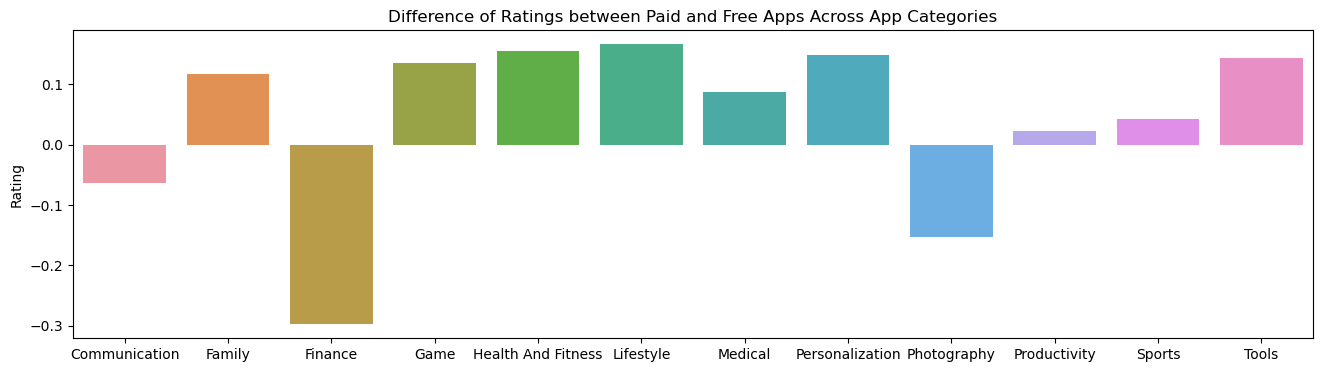

In [25]:
fig, ax = plt.subplots(figsize=(16,4))
sorted_idx = sorted(paid_stats.index)
rating_diff = paid_stats[sorted_idx] - free_stats[sorted_idx]
sns.barplot(x=sorted_idx, y=rating_diff, ax=ax).set_title("Difference of Ratings between Paid and Free Apps Across App Categories");
rating_diff

#### Interpretation
Although paid apps are in general more highly-rated than free apps, and so are in most app categories, there are still some app categories where free apps are likely to be favored more than the paid apps. For instance, COMMUNICATION, FINANCE and PHOTOGRAPHY are three such categories. In FINANCE category, the free apps on average are rated almost 0.3 higher than the paid apps, which is also the largest difference between app types across all the categories.


### Q3 Are there any categories where the differences are statistically significant?

In [26]:
def compute_utest(df):
    """
    Compute Mann-Whitney rank tests
    for paid and free app ratings
    """
    paid_rating = df.query('Type == "Paid"')['Rating']
    free_rating = df.query('Type == "Free"')['Rating']
    return mannwhitneyu(paid_rating, free_rating)

def cat_utest(df):
    """
    Iteratively compute utest for each app category
    """
    cats = set(df.Category)
    res = []
    for cat in cats:
        stats, pval = compute_utest(df.query('Category == "{}"'.format(cat)))
        res.append({'Category':cat,
                    'u_statistics':stats,
                    'p_value':pval})
    return pd.DataFrame(res)

uval, pval = compute_utest(df_rating)

print("General utest result: pval {}, u {}".format(pval, uval))
df_utest = cat_utest(df_rating)   
df_utest.loc[df_utest.p_value < .05] # significant categories

General utest result: pval 7.073262096170448e-10, u 1626957.0


,Category,u_statistics,p_value
5,Family,133234.0,0.000053
8,Personalization,9137.5,0.004496
9,Game,39535.0,0.000382
10,Tools,24898.0,0.006077


In [27]:
df.corr()

,Unnamed: 0.1,Unnamed: 0,Rating,Reviews,Size,Installs,Price
Unnamed: 0.1,1.000000,0.999571,-0.123565,-0.092450,-0.004724,-0.115358,-0.002715
Unnamed: 0,0.999571,1.000000,-0.124091,-0.092332,-0.005205,-0.114801,-0.001452
Rating,-0.123565,-0.124091,1.000000,0.059430,0.041181,0.042372,-0.021316
Reviews,-0.092450,-0.092332,0.059430,1.000000,0.056789,0.611471,-0.008080
Size,-0.004724,-0.005205,0.041181,0.056789,1.000000,-0.005860,-0.017899
Installs,-0.115358,-0.114801,0.042372,0.611471,-0.005860,1.000000,-0.009859
Price,-0.002715,-0.001452,-0.021316,-0.008080,-0.017899,-0.009859,1.000000


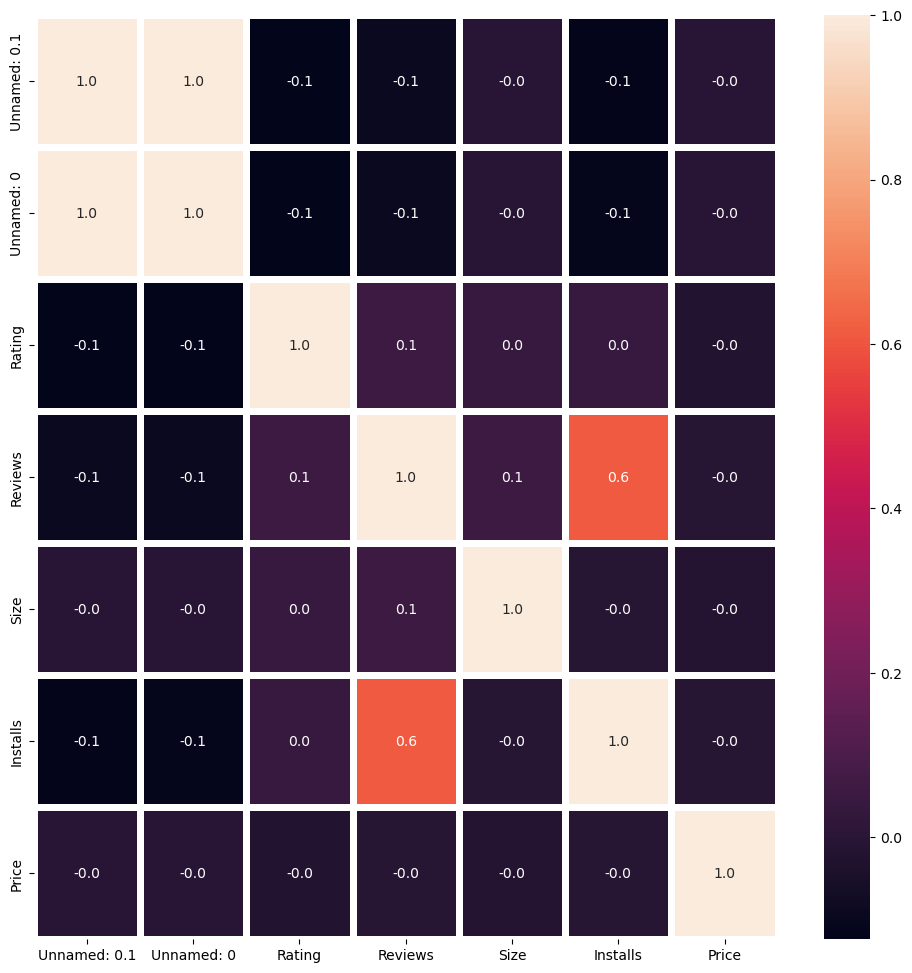

In [28]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(),annot=True,linewidths=5,fmt='.1f',ax=ax)
plt.show()

#### Interpretation
As rating is not normally-distributed, Mann-Whitney's U test was applied to test the significance of rating differences, since this test is free from a normal assumption. At the 0.05 significance level, results of the u tests on different categories demonstrate that the free and paid apps in the following categories have significant rating differences: personalization, tools, family and games. Paid apps are on average higher rated than free apps in these categories.

### Concluding Remarks

Data analysis was conducted on the Kaggle Google Play Store dataset, the answers to the three questions were explored:
- How do the ratings differ between paid and free apps in general?
  In general, Paid apps are better-rated than free apps, which appears to support the argument that service quility of the paid apps is better.
- How are the differences distributed across different app categories?
  In most categories, Paid apps achieve higher ratings than free apps, however, in a few categories such as COMMUNICATION, FINANCE and PHOTOGRAPHY, the average ratings of free apps are higher than those of paid apps. Is this because many popular apps in these categories are free, like facebook and whatsapp in the COMMUNICATION category?
- Are there any categories where the differences are statistically significant?
  There are four categories (PERSONALIZATION, TOOLS, FAMILY and GAME) where paid apps are rated significantly higher than free apps.
  
This is only a very superficial exploration of the Google Play Store dataset. There are many other useful information including installation counts and app review texts, which might entail many more interesting facts and await further exploration.
  

  



## THANK YOU!!